In [7]:
!pip install numpy matplotlib

  Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp312-cp312-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached numpy-2.3.5-cp312-cp312-win_amd64.whl (12.8 MB)
Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)
Using cached pillow-12.0.0-cp312-cp312-win_amd64.wh

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion

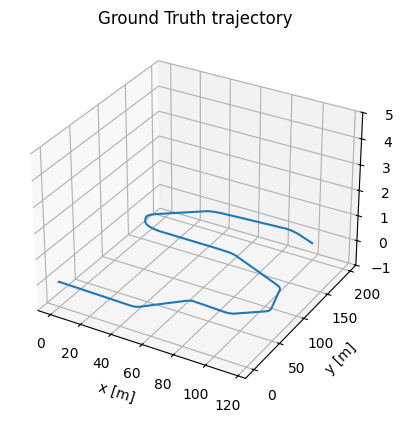

In [27]:
#### 1. Data ###################################################################################

################################################################################################
# This is where you will load the data from the pickle files. For parts 1 and 2, you will use
# p1_data.pkl. For Part 3, you will use pt3_data.pkl.
################################################################################################
with open('data/pt3_data.pkl', 'rb') as file:
    data = pickle.load(file)

################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

################################################################################################
# Let's plot the ground truth trajectory to see what the vehicle is doing.
################################################################################################
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [28]:
################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can insert it into our solver as another position measurement,
# just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
# IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our 
# known extrinsic calibration rotation matrix C_li and translation vector t_i_li.
#
# THIS IS THE CODE YOU WILL MODIFY FOR PART 2 OF THE ASSIGNMENT.
################################################################################################
# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

# ##Incorrect calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.05).
# C_li = np.array([
#      [ 0.9975 , -0.04742,  0.05235],
#      [ 0.04992,  0.99763, -0.04742],
#      [-0.04998,  0.04992,  0.9975 ]
# ])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li


In [29]:

#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

# IMU continuous noise covariance (6x6): accel noise then gyro noise
Q_imu = np.diag([var_imu_f]*3 + [var_imu_w]*3)


################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian


In [31]:

#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0


In [32]:
from rotations import skew_symmetric, Quaternion
q = Quaternion(1, 0.2, 0.3, 0.4)  # w,x,y,z depending on your class, just a test
print(skew_symmetric(np.array([[1],[2],[3]])))
print(q.to_mat())


[[ 0. -3.  2.]
 [ 3.  0. -1.]
 [-2.  1.  0.]]
[[ 0.79 -0.68  0.76]
 [ 0.92  0.89 -0.16]
 [-0.44  0.64  1.03]]


In [33]:
from rotations import Quaternion
q = Quaternion(1, 0.2, 0.3, 0.4).normalize()
C = q.to_mat()
print(C.shape)
print(C)


(3, 3)
[[ 0.6124031  -0.52713178  0.58914729]
 [ 0.71317829  0.68992248 -0.12403101]
 [-0.34108527  0.49612403  0.79844961]]


In [34]:

#### 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    """
    Error-state ES-EKF measurement update for a position measurement y_k.
    Error state: [dp(3), dv(3), dtheta(3)]  => 9x1
    """
    # Measurement Jacobian (3x9): position-only measurement
    H = h_jac  # already defined: H[:, :3] = I

    # Measurement noise (3x3)
    R = sensor_var * np.eye(3)

    # Innovation / residual (3x1)
    r = (y_k - p_check).reshape(3,)

    # Kalman gain
    S = H @ p_cov_check @ H.T + R
    K = p_cov_check @ H.T @ np.linalg.inv(S)

    # Error-state update (9x1)
    delta_x = (K @ r).reshape(9,)

    dp = delta_x[0:3].reshape(3,)
    dv = delta_x[3:6].reshape(3,)
    dth = delta_x[6:9].reshape(3,)

    # Correct nominal state
    p_hat = p_check + dp
    v_hat = v_check + dv

    # Small-angle quaternion update: q_hat = dq ⊗ q_check
    dq = Quaternion(axis_angle=dth)            # rotations.py usually supports this
    q_hat = (dq * Quaternion(*q_check)).normalize().to_numpy()

    # Joseph-form covariance update (numerically safer)
    I = np.eye(9)
    p_cov_hat = (I - K @ H) @ p_cov_check @ (I - K @ H).T + K @ R @ K.T

    return p_hat, v_hat, q_hat, p_cov_hat

#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = (imu_f.t[k] - imu_f.t[k - 1]) / 1000.0


    # 1. Update state with IMU inputs

    # Grab previous nominal state
    p_prev = p_est[k-1]
    v_prev = v_est[k-1]
    q_prev = Quaternion(*q_est[k-1])

    # IMU measurements at time k
    f_k = imu_f.data[k].reshape(3,)   # specific force in body frame
    w_k = imu_w.data[k].reshape(3,)  # angular velocity in body frame

    # Rotation from body->inertial using previous orientation
    C = q_prev.to_mat()   # rotation matrix from body to inertial frame

    # 1) Nominal state predict
    # -------------------------
    # Orientation update (integrate gyro)
    dq = Quaternion(axis_angle=w_k * delta_t)
    q_check_obj = q_prev.quat_mult_left(dq, out='Quaternion').normalize()

    # Acceleration in inertial frame
    a_inertial = C @ f_k + g

    # Velocity + position integration
    v_check = v_prev + a_inertial * delta_t
    p_check = p_prev + v_prev * delta_t + 0.5 * a_inertial * (delta_t**2)

    q_check = q_check_obj.to_numpy()
    # 1.1 Linearize the motion model and compute Jacobians
    F = np.eye(9)
    F[0:3, 3:6] = np.eye(3) * delta_t
    F[3:6, 6:9] = -C @ skew_symmetric(f_k) * delta_t
    F[6:9, 6:9] = np.eye(3) - skew_symmetric(w_k) * delta_t

    # 2. Propagate uncertainty
    # --------------------------------
    # Map IMU noise into error-state; l_jac is 9x6 with identity in rows 3: (dv,dtheta)
    # Discrete noise scaling: dt^2 is the usual choice in this assignment
    Qd = Q_imu * (delta_t**2)

    p_cov_check = F @ p_cov[k-1] @ F.T + l_jac @ Qd @ l_jac.T

    # 3. Check availability of GNSS and LIDAR measurements
     # GNSS update (position)
    if gnss_i < gnss.data.shape[0] and gnss.t[gnss_i] == imu_f.t[k]:
        y_gnss = gnss.data[gnss_i]
        p_check, v_check, q_check, p_cov_check = measurement_update(
            var_gnss, p_cov_check, y_gnss, p_check, v_check, q_check
        )
        gnss_i += 1

    # LIDAR update (position, already transformed into IMU frame above)
    if lidar_i < lidar.data.shape[0] and lidar.t[lidar_i] == imu_f.t[k]:
        y_lidar = lidar.data[lidar_i]
        p_check, v_check, q_check, p_cov_check = measurement_update(
            var_lidar, p_cov_check, y_lidar, p_check, v_check, q_check
        )
        lidar_i += 1

    # -------------------------
    # Save the updated states
    # -------------------------
    p_est[k] = p_check
    v_est[k] = v_check
    q_est[k] = q_check
    p_cov[k] = p_cov_check



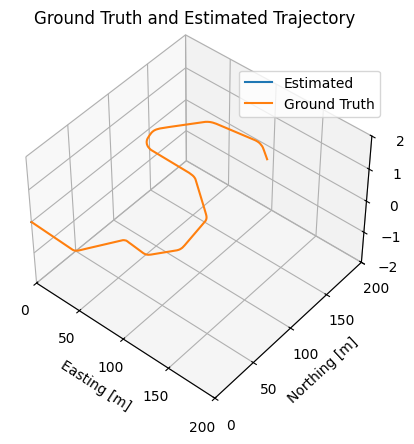

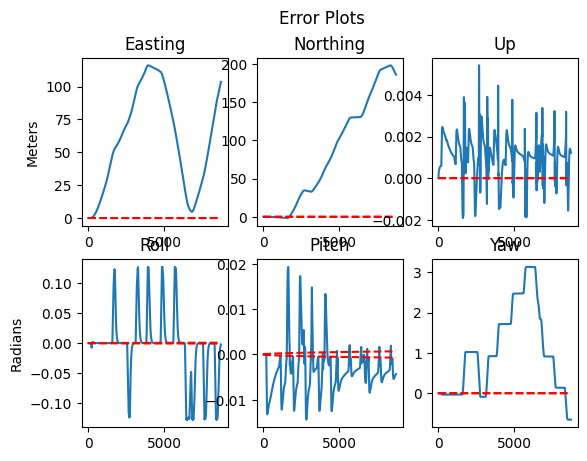

In [35]:

#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

################################################################################################
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty
# included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).
################################################################################################
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()


In [36]:

#### 7. Submission #############################################################################

################################################################################################
# Now we can prepare your results for submission to the Coursera platform. Uncomment the
# corresponding lines to prepare a file that will save your position estimates in a format
# that corresponds to what we're expecting on Coursera.
################################################################################################

# # Pt. 1 submission
# p1_indices = [9000, 9400, 9800, 10200, 10600]
# p1_str = ''
# for val in p1_indices:
#     for i in range(3):
#         p1_str += '%.3f ' % (p_est[val, i])
# with open('pt1_submission.txt', 'w') as file:
#     file.write(p1_str)

# # Pt. 2 submission
# p2_indices = [9000, 9400, 9800, 10200, 10600]
# p2_str = ''
# for val in p2_indices:
#     for i in range(3):
#         p2_str += '%.3f ' % (p_est[val, i])
# with open('pt2_submission.txt', 'w') as file:
#     file.write(p2_str)

# #Pt. 3 submission
p3_indices = [6800, 7600, 8400, 9200, 10000]
p3_str = ''
for val in p3_indices:
    for i in range(3):
        p3_str += '%.3f ' % (p_est[val, i])
with open('pt3_submission.txt', 'w') as file:
    file.write(p3_str)